<font color=darkred>

# Soc220: Computational Text Analysis
## Lab 7 (Week 9): Clustering and "vanilla" topic models (or, the inductive reasoning lab!)

<br>


<img src="images/dubois_3.png" style="width: 900px;" style="height: 900px;"/>

<img src="images/dubois_2.png" style="width: 800px;"/>

***

Today:

- LASSO and variable subselection just as an illustration for ML?
- Cross-validation and ML review.
- k-means clustering
- hierarchical clustering
- vanilla topic models
- visualization of topic models

***
    
   

<font color=darkgreen>

#### LASSO Example

https://github.com/zwehrwein/hn_round1_lasso/blob/master/hn_ds_analysis.ipynb

### Load data

- These data are transcripts of the proceedings in The House of Commons from 1660 to 1730.
- We organized these data in two ways: one by date of session and another by monarch (where each doc are all of the proceedings that occured under that King and/or Queen)

In [5]:
!ls

df_proceedings_monarch_and_date.p lab7.ipynb
images


In [6]:
# turn off warnings for some depreciated
import warnings
warnings.filterwarnings('ignore')

In [7]:
# import pickled data (data frames)
import pickle

df_texts = pickle.load(open("df_proceedings_monarch_and_date.p","rb"))

In [8]:
import pandas as pd

df_texts.head()

,date,monarch,text
0,1660_11,charles2,On the sixth of November the Parliament met ac...
1,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree..."
2,1661_11,charles2,After a Recess of almost four Months the Parli...
3,1661_5,charles2,"On the 8th of May the new Parliament met, and ..."
4,1663_2,charles2,"On February 18, 16623. the Parliament met afte..."


In [9]:
df_texts.tail()

,date,monarch,text
106,1738_2,george2,'Feb. 3. Sir Charles Turner being in the Chair...
107,1738_3,george2,'Wednes. March 3. Mr. Alderman Perry presente...
108,1738_4,george2,", ' April 7th. Mr. Speaker reported that the H..."
109,1738_5,george2,", "" Friday May 12. About 12 o'Clock Mr. Pulten..."
110,1739_2,george2,", ""Thursday, Feb. 1. A Message came by Sir Cha..."


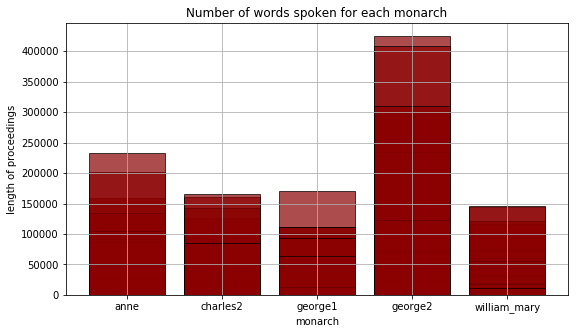

In [10]:
# visualize distribution of words

import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.bar(df_texts['monarch'], df_texts['text'].apply(len).values, color = "darkred", alpha = 0.7, edgecolor="white")
plt.title('Number of words spoken for each monarch')
#plt.xticks(df_texts['monarch'], df_texts['text'].values, rotation=45)
plt.xlabel('monarch')
plt.ylabel('length of proceedings')
plt.grid()

plt.show()

In [11]:
# TSNE to get some sense of the data as well
# Using a TfidfVect that is requiring a minimal frequency plus removing stop words
# Using the Grimmer and Stewart standard 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf  = TfidfVectorizer(min_df=0.2,stop_words='english')
texts  = tfidf.fit_transform(df_texts.text)

#infuriating error code: "Pd.series not unqiue"; hack fix: exit pandas to a list.
labels = df_texts['monarch'].tolist()

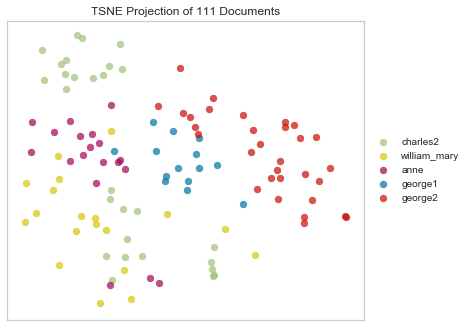

In [12]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(texts,labels)
tsne.poof()

<font color=darkgreen>

## k-means clustering

- Finds k clusters iteratively using random intializations.
- Useful for finding latent groups from data
- Filiz's new book uses this well.
- Notice no dependent variable!

Give a set of observations, k-means aims to partion the n observations $k \leq n$ into sets $s$ where each set minimizes the winthin-cluster sum of squares / variance:

### $$\underset{s}{\operatorname{argmin}} \sum^k_{i=1}\sum_{x_n \in S_i} \parallel x_n - \mu_i \parallel^2$$



***


<img src="images/kmeans_wiki.gif" style="width: 400px;"/>


In [13]:
#same as before. import function from sklearn, create an instance of it, and then fit it
#NEXT CLASS: HOW TO SELECT K

from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=6)
clusters.fit(texts) #give it a tf-idf transformed data

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
#from yellowbrick document:
tsne = TSNEVisualizer()
tsne.fit(texts, ["c{}".format(c) for c in clusters.labels_])

TSNEVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x119ef0978>,
        classes=None, colormap=None, colors=None, decompose=None,
        decompose_by=None)

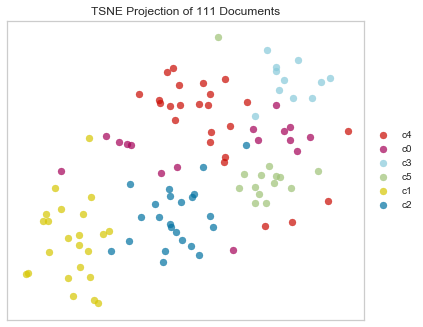

In [15]:
tsne.poof()

In [16]:
kmeans_df = pd.DataFrame({
    'kmeans cluster': clusters.labels_,
    'date':df_texts.date
})

kmeans_df.tail()

,date,kmeans cluster
106,1738_2,1
107,1738_3,1
108,1738_4,1
109,1738_5,1
110,1739_2,1


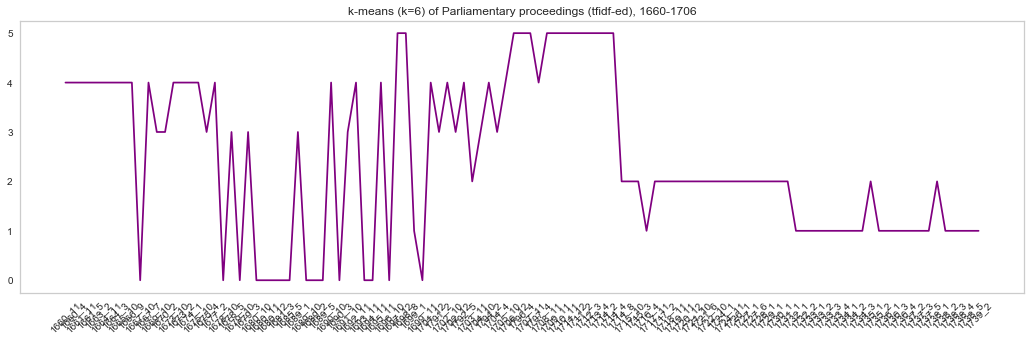

In [17]:
#plot k-means cluster over time
plt.figure(figsize=(18, 5))
plt.plot(kmeans_df.date,kmeans_df['kmeans cluster'],color='purple')
plt.xticks(df_texts.date[::], rotation=45)
plt.title('k-means (k=6) of Parliamentary proceedings (tfidf-ed), 1660-1706')
plt.grid()
plt.show()

<font color=darkgreen>

## Hierarchical clustering


1.) Use a distance metric to calculate how close certain vectors are (here, cosine similarity).

<img src="images/cosine.png" style="width: 400px;"/>

2.) Then, several ways to do linkages:

- Single linkage: the distance between two clusters is defined as the shortest distance between two points in each cluster.
- Complete linkage: the distance between two clusters is defined as the longest distance between two points in each cluster.
- Average linkage: you guessed it, the average distance between each point in one cluster to every point in the other cluster.

3.) The iterative steps are as follows: compute the distance between each of the clusters (using the specified linkage method) and continue to join the two most similar clusters together and continute to do so until there is one cluster left.

***

<img src="images/hierarch.gif" style="width: 800px;"/>

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram

In [19]:
# calculate cosine similarity for the tfidf dtm:
cosine_sim_texts = cosine_similarity(texts)

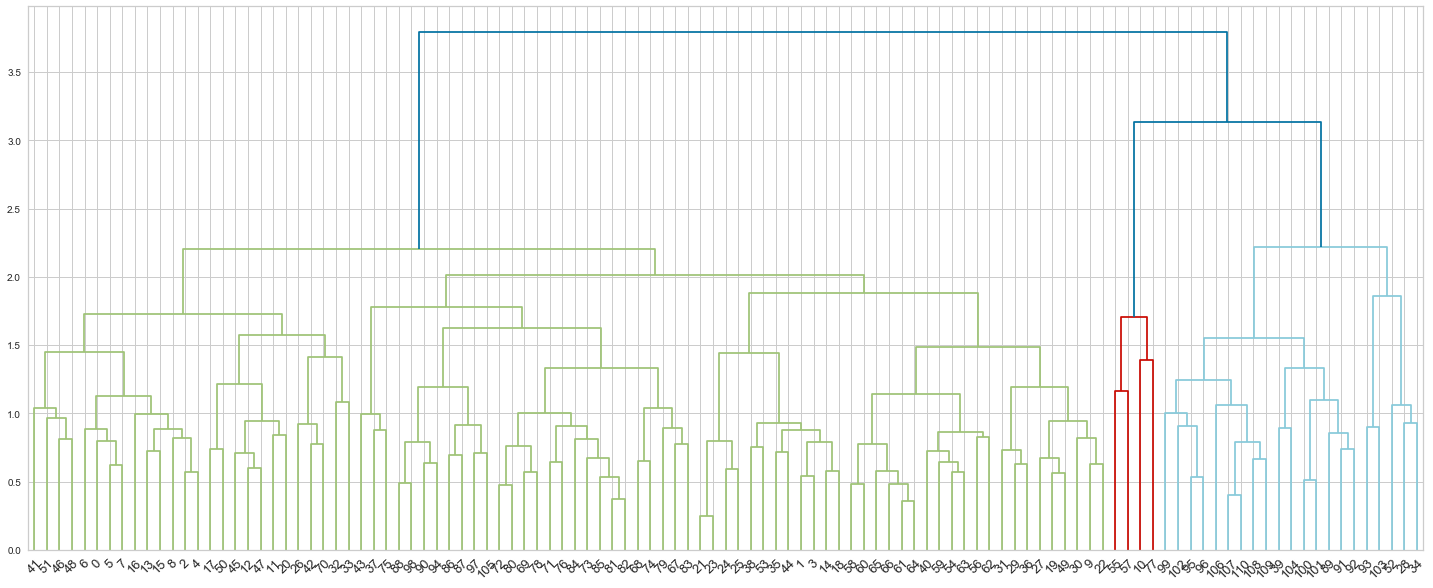

In [20]:
#'complete' clustering, aka the Farthest Point Algorithm
mergings = linkage(cosine_sim_texts, method='complete')

#this is creating an extra large figure size
fig = plt.figure(figsize=(25,10))

dendrogram(mergings,
           leaf_rotation=45,
           leaf_font_size=13,
)
plt.show()

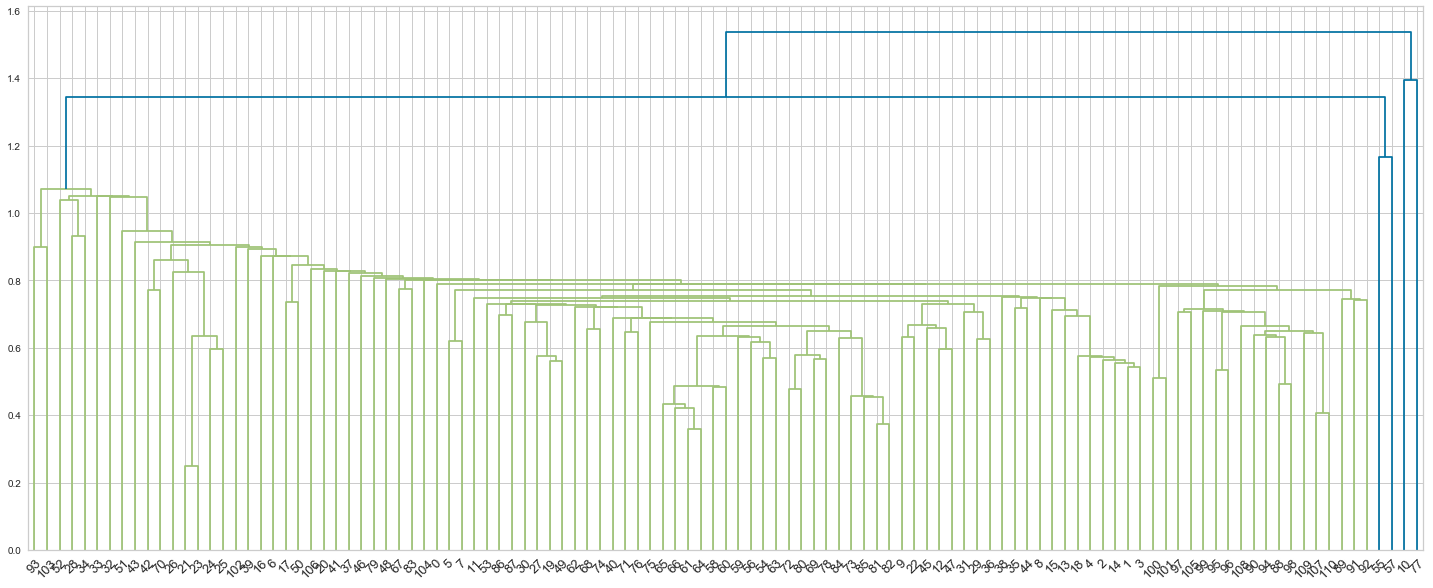

In [21]:
#'single' clustering, aka the Nearest Point Algorithm
mergings = linkage(cosine_sim_texts, method='single')

fig = plt.figure(figsize=(25,10))

dendrogram(mergings,
           leaf_rotation=45,
           leaf_font_size=13,
)
plt.show()

<font color=darkgreen>

#### Clearly something is going in in 55, 57, 10, 77. They are the first cluster computed when we ask for shortest distance and the last calculated when we ask for furthest distance. Upon inspect they're addresses from the Crown to open Parliament (hence the April dates) and they are all discussing religion.

In [22]:
# clearly something is going on in 55, 57, 10 17
df_texts.iloc[55,]

date                                                  1706_4
monarch                                                 anne
text        'During this Recess the grand Affair of the U...
Name: 55, dtype: object

In [23]:
df_texts.iloc[57,]

date                                                  1707_4
monarch                                                 anne
text       'My Lords and Gentlemen,", "I was willing to g...
Name: 57, dtype: object

In [24]:
df_texts.iloc[10,]

date                                                  1667_7
monarch                                             charles2
text        "In obedience to the King's Proclamation, but...
Name: 10, dtype: object

In [25]:
df_texts.iloc[17,]

date                                                  1675_4
monarch                                             charles2
text        "On the 13th Day of April both Houses of Parl...
Name: 17, dtype: object

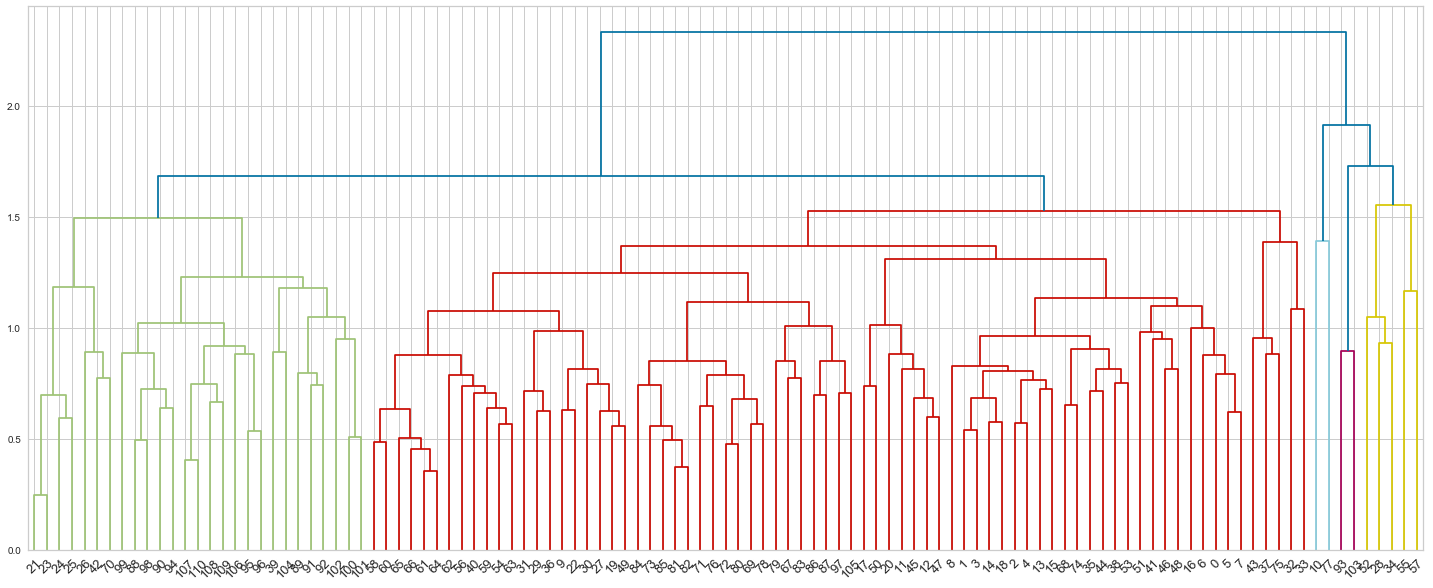

In [26]:
mergings = linkage(cosine_sim_texts, method='average')

fig = plt.figure(figsize=(25,10))

dendrogram(mergings,
           leaf_rotation=45,
           leaf_font_size=13,
           
)
plt.show()

***
***
<font color=darkgreen>

# 'Vanilla' topic model: Latent Dirichlet Allocation


<img src="images/Illustrating_LDA.jpg" style="width: 700px;"/>


- We care about three things:
1) documents
2) words
3) topics

- We assume that within and across the documents, there are latent topics which can be induced by a Dirichlet (French, pronounced 'deer-uh-shlay') distribution. We then parameterize that process into a generative model that inductively searches for topics.

For a given docuemnt N in a corpus D for K topics. We draw $\eta$ (pronounced 'ee-ta') (per-topic word distribution) and $\alpha$ (per-document topic distribution) from the Dirichlet distribution.

<img src="images/blei_lda.png" style="width: 500px;"/>



For a given collection of documents, we wish to **infer** from a given word in a document, corpus $W_{d,n}$
- per-word topic distribution, $Z_{d,n}$
- per-document topic proportions, $\theta_d$
- per-corpus topic distributions, $\beta_k$


#### **The only thing that we specify is the number of topics (K) (the rest is inductive). (Though we'll see next week even a way to automate this.**

A technical treatment from our friends over in Gov:

https://scholar.harvard.edu/files/dtingley/files/multimod.pdf

An intuitive treatment:

https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation

- A multinomial distribution describes the outcomes of n experiments with k outcomes with probability p. The expectation, the average result, $E(X_i) = np_i$. Sometimes $np$ is written with the greek letter Phi ($\phi$).

- For one particular corpus, we can describe the distribution of k topics over n documents with probability p with a multinomial distribution. However, that just describes 1 set of outcomes.

- A Dirichlet distribution is a conjugate prior, that is, given a multinomial observation, the posterior is a Dirichlet.

- In the following diagram, the blue simplex is a Dirichlet distribution, within which are multinomial distributions which each have 3 trials with possible outcomes between 0 and 1.

- This Dirichlet representation thus describes all possible outcomes from all possible runs of 3 trials.


<img src="images/Dirichlet+Distribution.jpg" style="width: 500px;"/>

From the Blei reading:

## $$p(\beta_{1:k},\theta_{1:D},Z_{1:D},W_{1:D}) = \Pi_{i=1}^kp(\beta_i)\Pi_{d=1}^D(\theta_d) (\Pi^n_{n=1}p(Z_{d,n}|\theta_d) p(w_{d,n}|\beta_{1:k},z_{d,n}))$$

#### - topic assignment ($Z_{d|n}$) depends on the per-document topic proportions $\theta_d$.
#### - a given word ($w_{d|n}$) depends on the topic assignment and *all* of the topics $\beta_{1:k}$.

<font color=darkblue>

#### From wiki, an animation of a topic model in action:

1. Words are sorted into topics.
2. And then documents' topics are sorted.

<img src="images/tm_wiki_animation.gif" style="width: 500px;"/>

<font color=darkred>

n.b. We are no longer in TFIDF land because LDA works off of integer counts.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [30]:
tf_vectorizer = CountVectorizer(
                                #strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=None,
                                max_df = 0.80, #ignore words that appear in over 90% of documents 
                                min_df = .10 #ignore words that appear in less than 10% of documents
)

In [31]:
dtm_tf = tf_vectorizer.fit_transform(df_texts['text'])
print(dtm_tf.shape)

(111, 3827)


In [36]:
lda_tf = LatentDirichletAllocation(n_topics=25,random_state=450, max_iter=20, verbose=1)# , random_state=450, max_iter=20, verbose=1
lda_tf.fit(dtm_tf)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=20,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=25,
             perp_tol=0.1, random_state=450, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

<font color=darkred>

1.) interactive library exists to look at topic models called pyLDAvis (python LDA visualization).
- Blue bars are words that appear across the corpus
- Red bars are words exclusive to a given topic


2.) n.b. they supply two metrics from the topic models literature:

Relevance: " Change the value of λ to adjust the term rankings -- small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic. A user study described in our paper suggested that setting λ near 0.6 aids users in topic interpretation, although we expect this to vary across topics and data sets (hence our tool, which allows you to flexiby adjust λ)."

3.) They use multidimensional scaling, a species of principal components analysis to visualize.

In [37]:
#!pip install pyLDAvis

In [35]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      32.277187        1       1 -0.051764 -0.050525
12     27.611396        1       2  0.027079  0.008840
21     25.414711        1       3  0.045990 -0.010236
5       7.919289        1       4 -0.154809  0.035112
13      6.267011        1       5 -0.014782 -0.103795
11      0.288216        1       6  0.018634  0.014556
3       0.201122        1       7  0.016031  0.008142
6       0.001170        1       8 -0.013959 -0.008113
10      0.001170        1       9 -0.002838 -0.001334
14      0.001170        1      10  0.011449 -0.001697
23      0.001170        1      11 -0.002868 -0.003125
2       0.001170        1      12  0.012770  0.002867
22      0.001170        1      13  0.010416  0.008520
7       0.001170        1      14 -0.001226 -0.002320
18      0.001170        1      15  0.002255  0.011653
15      0.001170        1      16  0.014780  0.006603
20      0.001170        1      17  0.006185  0.005384
0       0.001170        1      18  0.007046  0.006597
9       0.001170        1      19  0.007534  0.007898
16      0.001170        1      20  0.011145  0.010637
24      0.001170        1      21 -0.002582  0.014515
8       0.001170        1      22  0.012990  0.005732
17      0.001170        1      23  0.014790  0.010850
19      0.001170        1      24  0.012381  0.008993
4       0.001170        1      25  0.013357  0.014245, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
1596  Default  1669.000000      gentleman  1669.000000  30.0000  30.0000
2148  Default  1551.000000            man  1551.000000  29.0000  29.0000
2773  Default  1298.000000         public  1298.000000  28.0000  28.0000
328   Default  1217.000000           army  1217.000000  27.0000  27.0000
2275  Default  1349.000000         motion  1349.000000  26.0000  26.0000
2774  Default  1096.000000        publick  1096.000000  25.0000  25.0000
2116  Default   941.000000      lordships   941.000000  24.0000  24.0000
0     Default  1041.000000            000  1041.000000  23.0000  23.0000
442   Default   962.000000        believe   962.000000  22.0000  22.0000
3259  Default  1118.000000          spain  1118.000000  21.0000  21.0000
1733  Default   958.000000     honourable   958.000000  20.0000  20.0000
3385  Default   920.000000            sum   920.000000  19.0000  19.0000
2922  Default   812.000000       religion   812.000000  18.0000  18.0000
1966  Default   777.000000           john   777.000000  17.0000  17.0000
665   Default   785.000000  commissioners   785.000000  16.0000  16.0000
2195  Default   852.000000         member   852.000000  15.0000  15.0000
3548  Default   888.000000         treaty   888.000000  14.0000  14.0000
2524  Default   770.000000       petition   770.000000  13.0000  13.0000
1189  Default   724.000000         duties   724.000000  12.0000  12.0000
1183  Default   763.000000           duke   763.000000  11.0000  11.0000
2401  Default   724.000000       officers   724.000000  10.0000  10.0000
2444  Default   686.000000           paid   686.000000   9.0000   9.0000
789   Default   730.000000   constitution   730.000000   8.0000   8.0000
2994  Default   802.000000    resolutions   802.000000   7.0000   7.0000
3280  Default   690.000000          spoke   690.000000   6.0000   6.0000
1192  Default   686.000000           earl   686.000000   5.0000   5.0000
2730  Default   720.000000       proposed   720.000000   4.0000   4.0000
2754  Default   659.000000     protestant   659.000000   3.0000   3.0000
683   Default   598.000000        company   598.000000   2.0000   2.0000
1323  Default   744.000000         europe   744.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2195  Topic25     0.004140         member   852.414329  -0.8797  -6.9768
328   Topic25    

<font color=darkred>

**n.b. pyLDAvis takes up a ton of memory!**